In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Use bo4ais library
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [19]:
# Change to double as recommended by BoTorch
ice = torch.load("data/ice_thickness_points_casey.pt", weights_only = False).double()

skiway_x_norm, skiway_y_norm = 0.7425144608040001, 0.4736784387760001
skiway = torch.tensor([[skiway_x_norm, skiway_y_norm]])

## Reduce data

In [3]:
REDUCE_RATE = 1000
ice_reduced = ice[::REDUCE_RATE]

# Fit GP

In [4]:
gp = SingleTaskGP(
    train_X = ice_reduced[:, 0:2],
    train_Y = ice_reduced[:, 2].unsqueeze(-1), # to retain explicit dim
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

# Initialise aquisition function

In [36]:
from botorch.acquisition import LogExpectedImprovement

# We are maximising this
logNEI = LogExpectedImprovement(model = gp, best_f = ice_reduced[:, 2].unsqueeze(-1).max())

# Next point

In [37]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)]).to(torch.double)

candidate, acq_value = optimize_acqf(
    logNEI, 
    bounds = bounds, 
    # Get batch of points, chosen jointly: Batch BO
    q = 1, 
    num_restarts = 5, 
    raw_samples = 5,
)

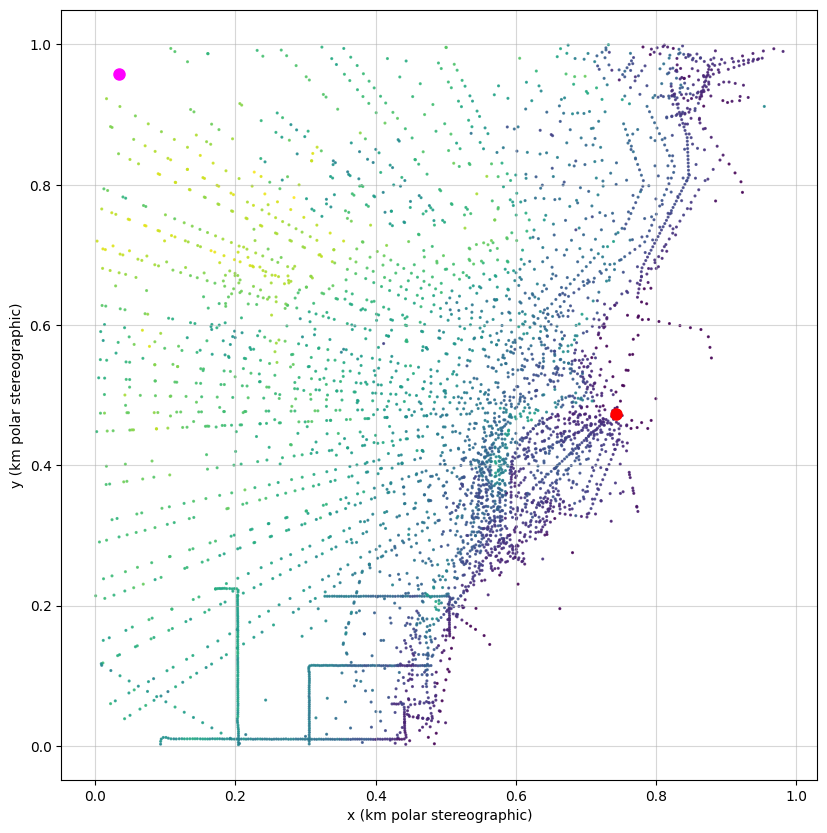

In [38]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice_reduced[:, 0], 
    ice_reduced[:, 1], 
    c = ice_reduced[:, 2], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidate[:, 0], 
    candidate[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "None",
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

## Batch BO

Not compatible withh all aquisition functions

In [18]:
NUM_BATCH = 20
from botorch.acquisition.monte_carlo import qExpectedImprovement

qEI = qExpectedImprovement(model = gp, best_f = ice_reduced[:, 2].max())

candidates, acq_values = optimize_acqf(
    acq_function = qEI,
    bounds = bounds,
    # Batch
    q = NUM_BATCH,
    num_restarts = 10,
    raw_samples = 128,
)

print(candidates.shape)

/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:394: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


torch.Size([20, 2])


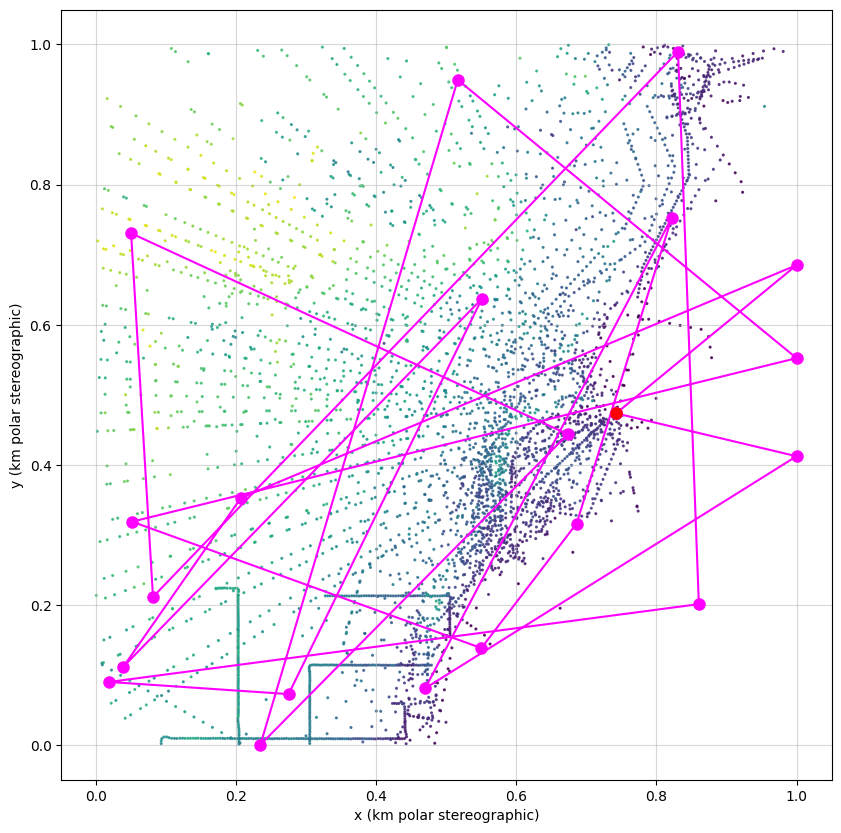

In [27]:
CONNECT_LINES = True
if CONNECT_LINES:
    # Add skiway as start and end point
    candidates = torch.concat((skiway, candidates, skiway), dim = 0)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    ice_reduced[:, 0], 
    ice_reduced[:, 1], 
    c = ice_reduced[:, 2], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(
    candidates[:, 0], 
    candidates[:, 1], 
    color = "magenta", 
    marker = "o", 
    markersize = 8, 
    linestyle = "solid" if CONNECT_LINES else "None",  # <- disables line
    label = "Candidate")

ax.plot(skiway_x_norm, skiway_y_norm, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Show aquisition function

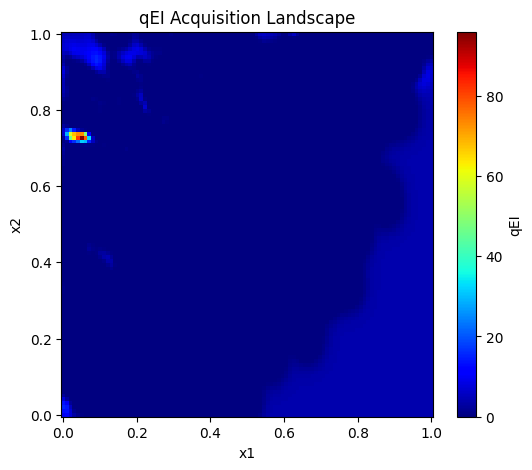

In [31]:
import torch
import matplotlib.pyplot as plt

# --- 2. Make a grid over [0,1]^2 (assuming you've normalised inputs) ---
grid_size = 100
x1 = torch.linspace(0, 1, grid_size)
x2 = torch.linspace(0, 1, grid_size)
X1, X2 = torch.meshgrid(x1, x2, indexing = "ij")
grid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

# --- 3. Evaluate acquisition function ---
with torch.no_grad():
    acq_values = qEI(grid.unsqueeze(1))  # shape [N, 1]
acq_values = acq_values.view(grid_size, grid_size).cpu()

# --- 4. Plot ---
plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(x1, x2, acq_values.T, shading = "auto", cmap = "jet")
plt.colorbar(pcm, label = "qEI")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("qEI Acquisition Landscape")
plt.show()

# ToDo:

- bounds: ice sheet only
    - With accept/reject
    - constraint https://archive.botorch.org/v/0.9.2/api/_modules/botorch/optim/parameter_constraints.html
- new aquisition function
- EI function: outlier in data? so focused function